# TensorFlow Lite End-to-End Android Application

By [Agventures]('https://github.com/diyaacharya/Krish-e')

For this project,  we will create an end-to-end Android application with TFLite.

 We opted to develop an **Android application that detects plant diseases**. 


The project is broken down into multiple steps:

* Building and creating a machine learning model using TensorFlow with Keras
* Deploying the model to an Android application using TFLite







##**Machine Learning  model using Tensorflow with Keras**

We designed algorithms and models to recognize species and diseases in the crop leaves by using Convolutional Neural Network


### **Importing  the Librairies**

In [ ]:
# Install nightly package for some functionalities that aren't in alpha
!pip install tf-nightly-gpu-2.0-preview

# Install TF Hub for TF2
!pip install 'tensorflow-hub == 0.4'


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
#tf.enable_eager_execution()

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
#from keras import optimizers




In [ ]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.0.0-dev20190514
Eager mode:  True
Hub version:  0.4.0
GPU is available


### Load the data
We will download a public dataset of 54,305 images of diseased and healthy plant leaves collected under controlled conditions ( [PlantVillage Dataset](https://storage.googleapis.com/plantdata/PlantVillage.tar)). The images cover 14 species of crops, including: apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soy, squash, strawberry and tomato. It contains images of 17 basic diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycete), 2 viral diseases and 1 disease caused by a mite. 12 crop species also have healthy leaf images that are not visibly affected by disease. Then store the downloaded zip file to the "/tmp/" directory.

we'll  need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.



In [ ]:
zip_file = tf.keras.utils.get_file(origin='https://storage.googleapis.com/plantdata/PlantVillage.zip', 
                                   fname='PlantVillage.zip', extract=True)


### Prepare training and validation  dataset
Create the training and validation directories 

In [ ]:
data_dir = os.path.join(os.path.dirname(zip_file), 'PlantVillage')
train_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'validation')


In [ ]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [ ]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : /root/.keras/datasets/PlantVillage/train : 43444files
total images for validation : /root/.keras/datasets/PlantVillage/validation : 10861files


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `categories.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plants and diseases.

In [ ]:
!!wget https://github.com/obeshor/Plant-Diseases-Detector/archive/master.zip
!unzip master.zip;

Archive:  master.zip
5efb5883fd88972332481e2c440cf3352bfa7310
replace Plant-Diseases-Detector-master/Plant_Diseases_Detector.ipynb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Plant-Diseases-Detector-master/Plant_Diseases_Detector.ipynb  
 extracting: Plant-Diseases-Detector-master/README.md  
  inflating: Plant-Diseases-Detector-master/_config.yml  
  inflating: Plant-Diseases-Detector-master/assets/Diseases classifier.jpeg  
  inflating: Plant-Diseases-Detector-master/assets/PlantVillagefarmer.jpg  
  inflating: Plant-Diseases-Detector-master/assets/detect_crop_disease_in_africa.png  
  inflating: Plant-Diseases-Detector-master/categories.json  


In [ ]:
import json

with open('Plant-Diseases-Detector-master/categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['pepper_bacterial_spot','pepper_fungal_pollu','pepper_lichen', 'pepper_red_rust']


In [ ]:
print('Number of classes:',len(classes))

Number of classes: 4


###Select the Hub/TF2 module to use

In [ ]:
module_selection = ("inception_v3", 299, 2048) #@param ["(\"mobilenet_v2\", 224, 1280)", "(\"inception_v3\", 299, 2048)"] {type:"raw", allow-input: true}
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(
  MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

BATCH_SIZE = 64 #@param {type:"integer"}

Using https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2 with input size (299, 299) and output dimension 2048


### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [ ]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


Found 10861 images belonging to 4 classes.
Found 43444 images belonging to 4 classes.


###Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE+(3,),
                                   output_shape=[FV_SIZE])




In [ ]:
do_fine_tuning = False #@param {type:"boolean"}
if do_fine_tuning:
  feature_extractor.trainable = True
  # unfreeze some layers of base network for fine-tuning
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False
    

In [ ]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    feature_extractor,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax',
                           kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
#model.build((None,)+IMAGE_SIZE+(3,))

model.summary()

Building model with https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                19494     
Total params: 22,871,366
Trainable params: 1,068,582
Non-trainable params: 21,802,784
_________________________________________________________________


### Specify Loss Function and Optimizer

In [ ]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



### Train Model
train model using validation dataset for validate each steps

In [ ]:

EPOCHS=5 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

Epoch 1/5
678/678 [==============================] - 965s 1s/step - loss: 1.1111 - accuracy: 0.7513 - val_loss: 0.6538 - val_accuracy: 0.8672
Epoch 2/5
678/678 [==============================] - 953s 1s/step - loss: 0.6846 - accuracy: 0.8554 - val_loss: 0.5505 - val_accuracy: 0.8972
Epoch 3/5
678/678 [==============================] - 939s 1s/step - loss: 0.6208 - accuracy: 0.8748 - val_loss: 0.5243 - val_accuracy: 0.9057
Epoch 4/5
678/678 [==============================] - 932s 1s/step - loss: 0.5906 - accuracy: 0.8838 - val_loss: 0.5074 - val_accuracy: 0.9123
Epoch 5/5
678/678 [==============================] - 928s 1s/step - loss: 0.5736 - accuracy: 0.8876 - val_loss: 0.4986 - val_accuracy: 0.9154


###Check Performance
Plot training and validation accuracy and loss

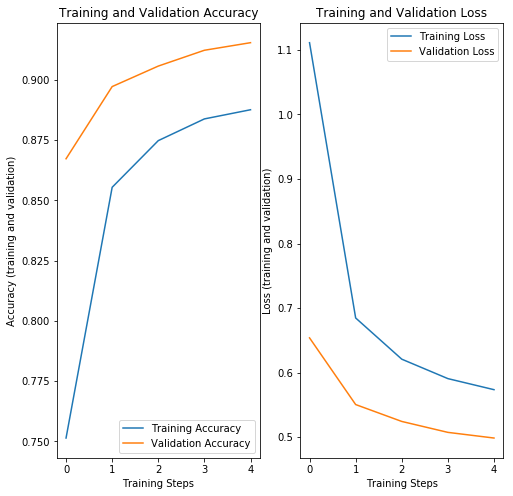

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

### Random test
Random sample images from validation dataset and predict

In [ ]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(data_dir, validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

## Export as saved model and convert   to TFLite
Now that you've trained the model, export it as a saved model

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
tf.keras.experimental.export_saved_model(model, export_path)

export_path

In [ ]:
# Now confirm that we can reload it, and it still gives the same results
reloaded = tf.keras.experimental.load_from_saved_model(export_path, custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
def predict_reload(image):
    probabilities = reloaded.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

In [ ]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 2)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict_reload(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
# convert the model to TFLite
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/plant_disease_model.tflite"


# Get the concrete function from the Keras model.
run_model = tf.function(lambda x : reloaded(x))

# Save the concrete function.
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)

# Convert the model to standard TensorFlow Lite model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)

## CONCLUSION
The model can be improved if you change some hyperparameters. You can try using a different pretrained model. It's up to you. Let me know if you can improve the accuracy! Let's develop an Android app that uses this model.